### EAO - easy and straight forward optimization of energy setups

#### Import required packages

In [1]:
import eaopack as eao
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

#### Load data & make assumptions
In this case we load a year of hourly power market data for Germany. Downloaded from smard.de (Bundesnetzagentur | SMARD.de); 01/11/2023 - 01/11/2024. We will use day ahead prices as well as PV production profiles. In addition we will use a standard load profile of German commercial consumers.

We make some basic assumptions on grid fees for commercial consumers (actual example for 2025 in the medium voltage grid) and define the characteristics on site: yearly consumption, own PV and battery.

In [2]:
data = pd.read_excel('DE_dataset.xlsx')
data.set_index('Date', inplace=True)

### at > 2500 FLH
grid_fees = {}
grid_fees['fix'] = 166000 # €/MW
grid_fees['var'] =     13 # €/MWh

######################### settings
cons    = 500 # MWh # total consumption per year (scaling the profile)
cap_pv  = 0.25 # MW (1000 flh) capacity of the on-site PV
battery_data = {} # capacity, size and efficiency of an on-site battery
battery_data['cap']  =  .25 # 250 kW
battery_data['size'] = 2 * battery_data['cap'] # 2 hours
battery_data['eff']  = 0.9 # 90% cycle efficiency

For the actual optimization we need to do some settings: Defining the time grid for optimization and defining which data to use in our assets.

In [3]:
######## prepare everything
## basics
S = dt.date(2023,11,1)
E = dt.date(2024,11,1)
timegrid = eao.Timegrid(S, E, freq = 'h') # hourly

## settings
input_ts = pd.DataFrame()
input_ts['cons']  = -data['SLP gewerbe']*cons
input_ts['pv']    =  data['pv profile']*cap_pv
input_ts['price'] =  data['price dah']

# cast to timegrid
input_ts = timegrid.prices_to_grid(input_ts)

Now we define the structure of our optimization problem -- our portfolio. The assets may be physical assets such as the battery or contracts such as supply via the grid.

In [4]:
### Structural setup, distinguishing own assets and supply from the grid
behind_meter = eao.Node('behind meter')
front_of_meter = eao.Node('front of meter')

### Here: No flexibility in our consumption. Easily changed by adjusting min_cap/max_cap
consumption = eao.assets.SimpleContract(name       = 'consumption', 
                                        nodes      = behind_meter,
                                        min_cap    = 'cons',
                                        max_cap    = 'cons')
### Our own PV module. Also here without flexibility -- easily changed
pv          = eao.assets.SimpleContract(name       = 'pv', 
                                        nodes      = behind_meter,
                                        min_cap    = 'pv',
                                        max_cap    = 'pv')
### An on-site battery constituting out flexibility
battery     = eao.assets.Storage(       name       = 'battery',
                                        nodes      = behind_meter,
                                        cap_in     = battery_data['cap'],
                                        cap_out    = battery_data['cap'],                                        
                                        eff_in     = battery_data['eff'],
                                        size       = battery_data['size'],
                                        start_level= 0.5 * battery_data['size'],
                                        end_level  = 0.5 * battery_data['size'],
                                        block_size = 'd',   # daily optimization of battery (leaving it 1/2 full every day)
                                        no_simult_in_out = False) # Important: The battery may now charge and discharge at the same time and
                                                                  # "burn" power due to efficiency < 100%. This makes computation much faster (no MIP)

### Supply via the grid. Note that we enabling scaling the grid connection -- since grid fees 
#   apply on a yearly basis for the maximum load (which we will minimize utilizing our battery)
supply  = eao.assets.SimpleContract(    name = 'supply', 
                                        nodes       = front_of_meter, 
                                        price       = 'price',
                                        extra_costs = .5,  # fee from supplier
                                        min_cap     = 0,
                                        max_cap     = 1)
grid_feedin = eao.assets.Transport(     name   = 'grid_out',  # unlimited feed in capacity
                                        nodes  = [behind_meter, front_of_meter],
                                        min_cap = 0,
                                        max_cap = 1)
grid_consumption_normed = eao.assets.Transport(name   = 'grid_in_normed', 
                                               nodes  = [front_of_meter, behind_meter],
                                               costs_const = grid_fees['var'], # variable grid fees
                                               min_cap= 0,
                                               max_cap= 1) # normed capacity (to 1 MW)
grid_consumption      = eao.assets.ScaledAsset(name       = 'grid_in',
                                               base_asset = grid_consumption_normed,
                                               max_scale  = 1000,
                                               fix_costs  = grid_fees['fix']/8760) # yearly fix capacity costs (here scaled to hourly as main time unit)
### We can feed in our PV own production - here at day ahead prices. If there are feed-in tariffs, price can easily be changed
feedin     = eao.assets.SimpleContract(name        = 'feedin', 
                                       nodes       = front_of_meter, 
                                       price       = 'price', # assuming no feed in tariff
                                       min_cap     = -1000,
                                       max_cap     = 0)
portf = eao.Portfolio([supply, consumption, grid_feedin, grid_consumption, pv, feedin, battery])

This is how the portfolio looks like. See below. We could set it up in a  simpler way (without distinction into in-front-of-the-meter and behind-the-meter). However, this way everything becomes very explicit in formulation as well as later analysis.

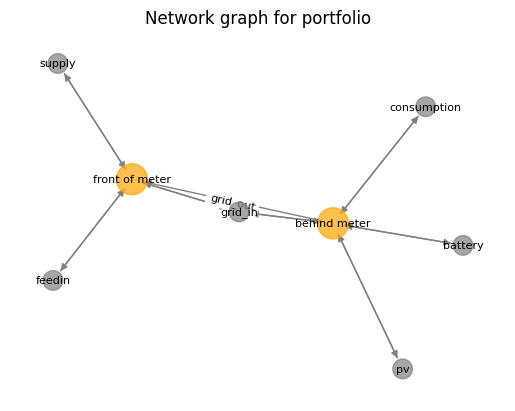

In [5]:
eao.network_graphs.create_graph(portf)

#### Optimization

The actual optimization is very simple. We collect all assets in the portfolio object and go. "extract_output" will generate straight-forward tables that can also be exported to Excel. Note that we are optimizing a full year on an hourly basis including a battery. This takes ~1 min.

In [6]:
out = eao.optimize(portf=portf, timegrid=timegrid, data=input_ts)
print(out['summary'])
eao.io.output_to_file(output=out, file_name='test.xlsx') ### All details. Have look into the file

                 Values
Parameter              
status       successful
value     -29974.687926


Defining the benchmark to calculate the value of the battery: The same portfolio without the battery

In [7]:
portf_benchmark = eao.portfolio.Portfolio([supply, consumption, grid_feedin, grid_consumption, pv, feedin])
out_benchmark   = eao.optimize(portf=portf_benchmark, timegrid=timegrid, data=input_ts)

#### Interpretation of the results

Let us analyze the overall costs with and without battery and look into the dispatch behaviour

In [8]:
print('Overall costs with battery:    '+ str(round(-out['summary'].loc['value', 'Values'])))
print('Overall costs without battery: '+ str(round(-out_benchmark['summary'].loc['value', 'Values'])))
print('So the battery saved us:       '+ str(round(out['summary'].loc['value', 'Values'] - out_benchmark['summary'].loc['value', 'Values'])))

Overall costs with battery:    29975
Overall costs without battery: 49494
So the battery saved us:       19519


There is a significant saving. But where does the saving come from? Let us look into the details, starting with the overall quantities. See below. Note how quantities are always balanced at nodes. Transport always balances as well -- transporting from one node to the other.

Check out the output "out" in detail. It contains detailed dispatch, cash flows and internal variables such as battery fill levels.

In [9]:
print('Quantities (MWh) with battery:\n.................................... \n'+str(round(out['dispatch'].sum())))
print()
print('Quantities (MWh) without battery:\n.................................... \n'+str(round(out_benchmark['dispatch'].sum())))

Quantities (MWh) with battery:
.................................... 
supply (front of meter)       376.0
consumption (behind meter)   -500.0
grid_out (behind meter)      -103.0
grid_out (front of meter)     103.0
grid_in (front of meter)     -376.0
grid_in (behind meter)        376.0
pv (behind meter)             250.0
feedin (front of meter)      -103.0
battery (behind meter)        -23.0
dtype: float64

Quantities (MWh) without battery:
.................................... 
supply (front of meter)       310.0
consumption (behind meter)   -500.0
grid_out (behind meter)       -60.0
grid_out (front of meter)      60.0
grid_in (front of meter)     -310.0
grid_in (behind meter)        310.0
pv (behind meter)             250.0
feedin (front of meter)       -60.0
dtype: float64


In [10]:
print('Costs (EUR) with battery:\n.................................... \n'+str(round(out['DCF'].sum())))
print('Total:  '+ str(out['DCF'].sum().sum().round())+'\n')
print('Costs (EUR) without battery:\n.................................... \n'+str(round(out_benchmark['DCF'].sum())))
print('Total:  '+ str(out_benchmark['DCF'].sum().sum().round())+'\n')

Costs (EUR) with battery:
.................................... 
supply        -26178.0
consumption        0.0
grid_out           0.0
grid_in       -15948.0
pv                 0.0
feedin         12152.0
battery            0.0
dtype: float64
Total:  -29975.0

Costs (EUR) without battery:
.................................... 
supply        -27711.0
consumption        0.0
grid_out           0.0
grid_in       -22788.0
pv                 0.0
feedin          1006.0
dtype: float64
Total:  -49494.0



There are two contributions:
* supply & PV: we are utilizing the battery to maximize own consumption, mainly to avoid variable grid fees
* battery & grid: we try to minimize peak load (capacity fee)
* battery arbitrage: utilizing the battery to consume from grid in cheap hours and feed in in expensive hours

Everything is optimized in a consistent manner in one go!

The grid connection is a special case: Besides avoiding variable grid fees, we're sizing the capacity over the course of the year, utilizing the battery to reduce peaks. Here the results. "Value" gives the required capacity:

In [11]:
print('Grid fixed costs (EUR) with battery:\n.................................................. \n'+str(out['special'].round(3))+'\n')
print('Grid fixed costs (EUR) without battery:\n.................................................. \n'+str(out_benchmark['special'].round(3)))

Grid fixed costs (EUR) with battery:
.................................................. 
     asset variable   name  value     costs
0  grid_in     size  scale  0.066  11058.95

Grid fixed costs (EUR) without battery:
.................................................. 
     asset variable   name  value      costs
0  grid_in     size  scale  0.113  18754.337


#### Another benchmark: Own PV
To make the picture more complete, let us add another step in the benchmark: to compute the value of the own PV (i.e. a portfolio without PV and battery as the overall starting point)

In [12]:
portf_start = eao.portfolio.Portfolio([supply, consumption, grid_feedin, grid_consumption, feedin])
out_start   = eao.optimize(portf=portf_start, timegrid=timegrid, data=input_ts)

#### Putting everything together

Let us now put all the data together to analyze the effects of our PV and battery assets. Naturally, we could also do this in Excel, using the output generated by the optimization. This may feel more natural to many users.

In [13]:
## bookkeeping - looking at cost components in different scenarios. Attention - costs are negative numbers
start  = -out_start['summary'].loc['value', 'Values'] # no assets
with_pv = -out_benchmark['summary'].loc['value', 'Values']  # PV, no battery
saving_supply = -((out_benchmark['DCF']['supply'].sum() + out_benchmark['DCF']['feedin'].sum())- (out['DCF']['supply'].sum() + out['DCF']['feedin'].sum()))
saving_grid   = -(out_benchmark['DCF']['grid_in'].sum() - out['DCF']['grid_in'].sum())

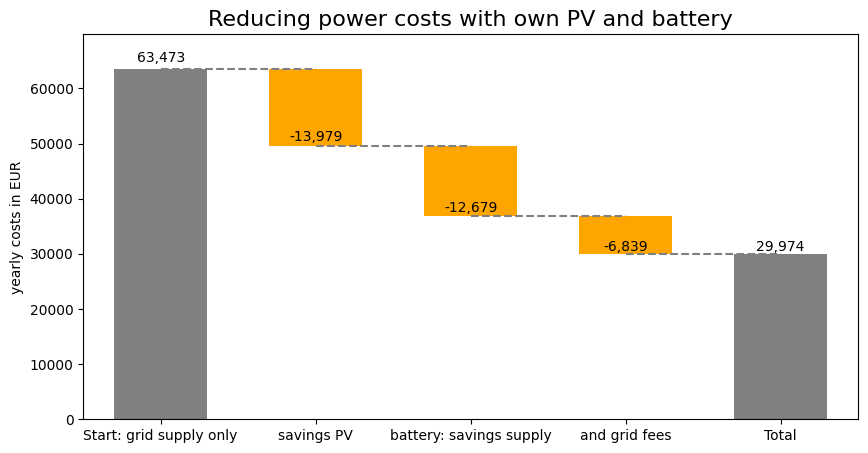

In [14]:
## create a waterfall chart. Thanks for the great module provided by the waterfall_ax team! Very handy
from waterfall_ax import WaterfallChart
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# Cumulative values
step_names = ['Start: grid supply only', 'savings PV',          'battery: savings supply','and grid fees']
step_values = [start,                     with_pv,               with_pv-saving_supply,    with_pv-saving_supply-saving_grid]
last_step_label = 'Total'
color_kwargs = {
    'c_bar_pos': 'lightgreen',
    'c_bar_neg': 'orange',
    'c_bar_start': 'grey',
    'c_bar_end': 'grey',
    'c_text_pos': 'black',    
    'c_text_neg': 'black',
    'c_text_start': 'black',
    'c_text_end': 'black'
}
# Plot
waterfall = WaterfallChart(step_values, step_names=step_names, last_step_label=last_step_label)
wf_ax = waterfall.plot_waterfall(title='Reducing power costs with own PV and battery', color_kwargs=color_kwargs)
plt.ylabel('yearly costs in EUR')
wf_ax.get_yaxis().set_visible(True)
plt.show()

... that was it! No rocket science, as you see.